In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d crowww/a-large-scale-fish-dataset
!unzip a-large-scale-fish-dataset.zip

In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import cv2
import random


In [4]:
# Loading the dataset

# Dataset path
dataset_path = '/content/Fish_Dataset/Fish_Dataset'

fish_classes = os.listdir(dataset_path) 
print(fish_classes)

# Creating dataframe of file path and class
df = pd.DataFrame(columns=['file_path', 'class'])
for fish_class in fish_classes:
    fish_class_path = os.path.join(dataset_path, fish_class)
    fish_class_files = os.listdir(fish_class_path)
    for fish_class_file in fish_class_files:
        fish_class_file_path = os.path.join(fish_class_path, fish_class_file)
        df = df.append({'file_path': fish_class_file_path, 'class': fish_class}, ignore_index=True)
    
df.head()




['Striped Red Mullet', 'Sea Bass', 'Hourse Mackerel', 'Red Mullet', 'Trout', 'Shrimp', 'Red Sea Bream', 'Gilt-Head Bream', 'Black Sea Sprat']


,file_path,class
0,/content/rooms_dataset/Striped Red Mullet/0070...,Striped Red Mullet
1,/content/rooms_dataset/Striped Red Mullet/0002...,Striped Red Mullet
2,/content/rooms_dataset/Striped Red Mullet/0027...,Striped Red Mullet
3,/content/rooms_dataset/Striped Red Mullet/0096...,Striped Red Mullet
4,/content/rooms_dataset/Striped Red Mullet/0066...,Striped Red Mullet


In [5]:
# Shuffling the dataset and resetting the index
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,file_path,class
0,/content/rooms_dataset/Striped Red Mullet/0049...,Striped Red Mullet
1,/content/rooms_dataset/Striped Red Mullet/0008...,Striped Red Mullet
2,/content/rooms_dataset/Black Sea Sprat/00047.png,Black Sea Sprat
3,/content/rooms_dataset/Sea Bass/00674.png,Sea Bass
4,/content/rooms_dataset/Red Sea Bream/00039.png,Red Sea Bream


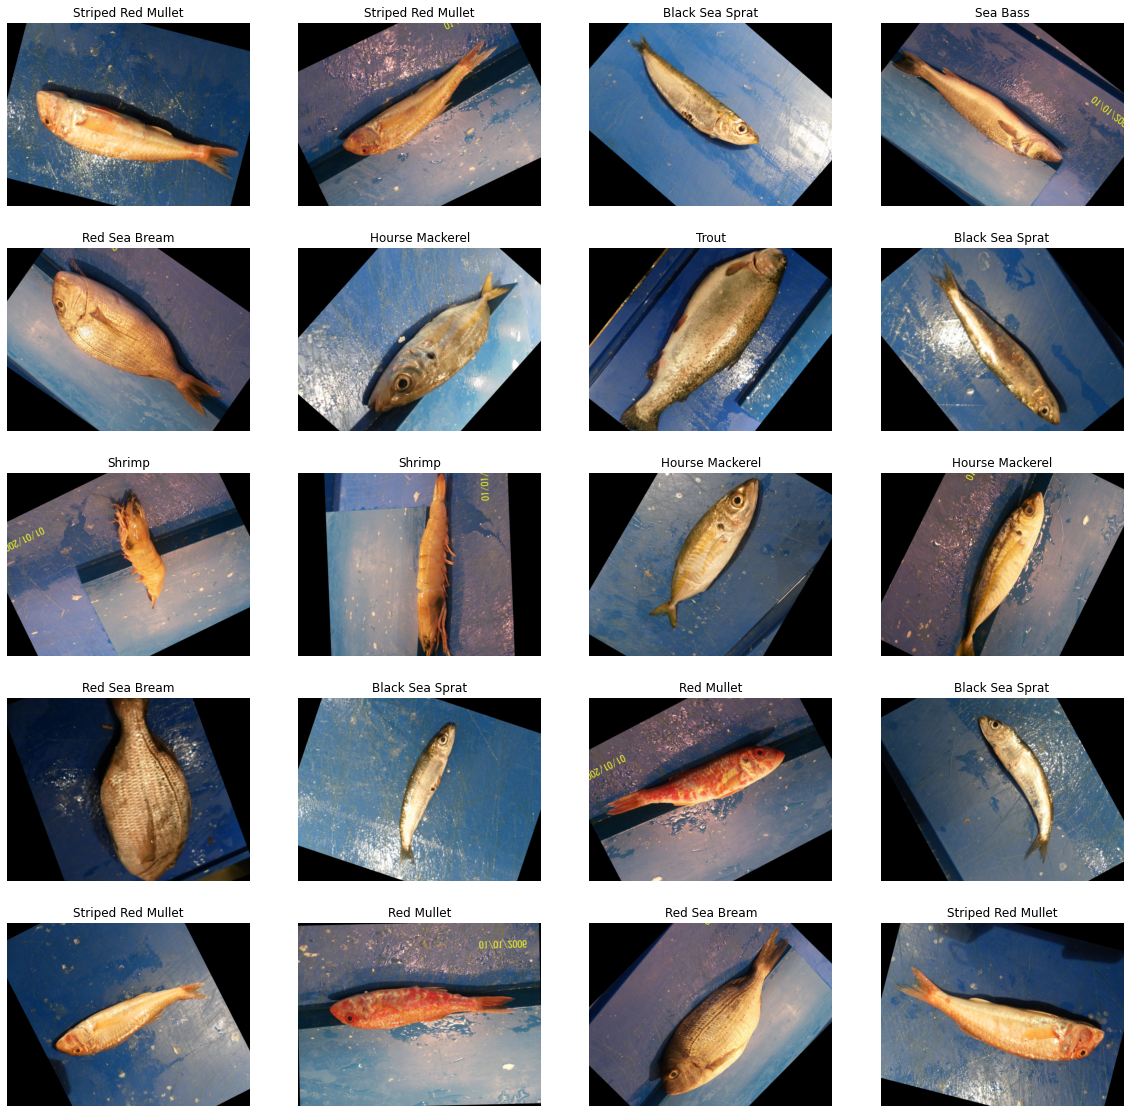

In [6]:
# Diplaying 20 pictures with their class
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5, 4, i+1)
    img = cv2.imread(df['file_path'][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(df['class'][i])
    plt.axis('off')
plt.show()


In [7]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df['file_path'], df['class'], test_size = 0.2, random_state = 0)



In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col="file_path",
    y_col="class",
    target_size=(75, 75),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col="file_path",
    y_col="class",
    target_size=(75, 75),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

test_images = test_generator.flow_from_dataframe(
    dataframe=df,
    x_col="file_path",
    y_col="class",
    target_size=(75, 75),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)
    

Found 7200 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.
Found 9000 validated image filenames belonging to 9 classes.


In [10]:
def create_model(input_shape = (75, 75, 3)):

    inputs = tf.keras.layers.Input(shape=input_shape)
    base_model = EfficientNetB7(include_top=False, weights='imagenet', input_tensor=inputs, classes = 9)

    x = base_model(inputs)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    outputs = tf.keras.layers.Dense(9, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    return model
    

In [11]:
model = create_model((75, 75, 3))
metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()



258088960/258076736 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 efficientnetb7 (Functional)  (None, 3, 3, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 9)                 23049     
                                                                 
Total params: 64,120,736
Trainable params: 63,810,009
Non-tr

In [12]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True, monitor='val_accuracy', mode='max'),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max'),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1, mode='max', min_delta=0.0001)]


In [13]:
# Training the model
history = model.fit(train_images, epochs=8, validation_data=validation_images, callbacks=callbacks)

Epoch 1/8
225/225 [==============================] - 162s 535ms/step - loss: 0.4043 - accuracy: 0.8714 - val_loss: 0.6496 - val_accuracy: 0.8950 - lr: 0.0010
Epoch 2/8
225/225 [==============================] - 119s 529ms/step - loss: 0.0815 - accuracy: 0.9731 - val_loss: 0.0744 - val_accuracy: 0.9767 - lr: 0.0010
Epoch 3/8
225/225 [==============================] - 109s 485ms/step - loss: 0.0416 - accuracy: 0.9885 - val_loss: 0.0069 - val_accuracy: 0.9983 - lr: 0.0010
Epoch 4/8
225/225 [==============================] - 99s 440ms/step - loss: 0.0397 - accuracy: 0.9889 - val_loss: 0.0583 - val_accuracy: 0.9861 - lr: 0.0010
Epoch 5/8
225/225 [==============================] - 100s 442ms/step - loss: 0.0415 - accuracy: 0.9886 - val_loss: 0.0085 - val_accuracy: 0.9961 - lr: 0.0010
Epoch 6/8
225/225 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9879
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
225/225 [==============================

In [15]:
# Visualizing the results test accuracy and test loss
test_loss, test_accuracy = model.evaluate(test_images)
print('Test accuracy :', test_accuracy)
print('Test loss :', test_loss)

282/282 [==============================] - 83s 295ms/step - loss: 6.5106e-04 - accuracy: 0.9999
Test accuracy : 0.9998888969421387
Test loss : 0.0006510574603453279


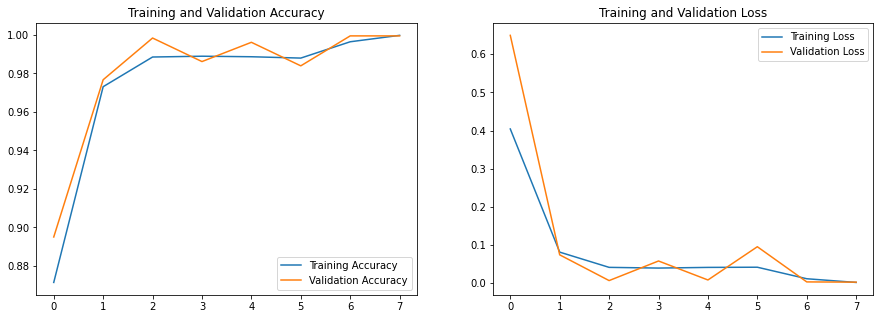

In [14]:
# Plotting accuracy and loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# Classification report
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
print('Classification Report')
print(classification_report(test_images.classes, y_pred, target_names=test_images.class_indices.keys()))

Classification Report
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00      1000
   Gilt-Head Bream       1.00      1.00      1.00      1000
   Hourse Mackerel       1.00      1.00      1.00      1000
        Red Mullet       1.00      1.00      1.00      1000
     Red Sea Bream       1.00      1.00      1.00      1000
          Sea Bass       1.00      1.00      1.00      1000
            Shrimp       1.00      1.00      1.00      1000
Striped Red Mullet       1.00      1.00      1.00      1000
             Trout       1.00      1.00      1.00      1000

          accuracy                           1.00      9000
         macro avg       1.00      1.00      1.00      9000
      weighted avg       1.00      1.00      1.00      9000



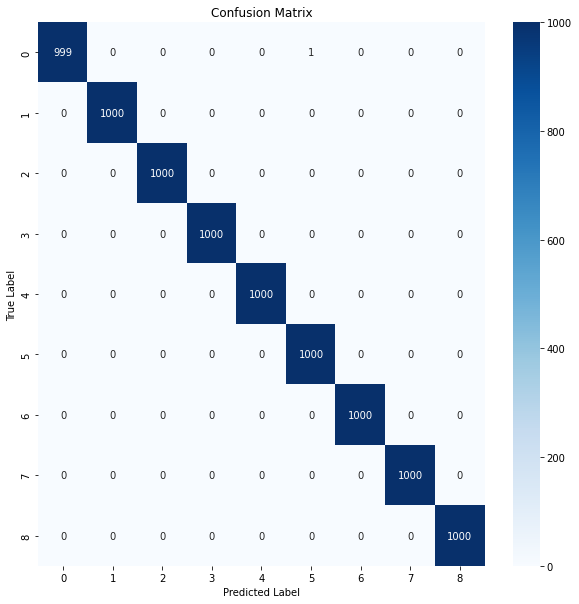

In [17]:
# Confusion matrix with heatmap
cm = confusion_matrix(test_images.classes, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()